In [1]:
import pickle
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from IPython.display import display
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier

from authorship_id.utils import set_seed

In [2]:
SEED = 42
set_seed(SEED)
dataset_dir = Path("../../enron_dataset")
ngram_ranges_to_test = [(1, 1), (2, 2), (3, 3)]
min_df_to_test = [1, 2]

In [3]:
with open(dataset_dir / "preprocessed_X.pkl", "rb") as f:
    preprocessed_X = pickle.load(f)
with open(dataset_dir / "preprocessed_y.pkl", "rb") as f:
    y_train, y_test = pickle.load(f)
with open(dataset_dir / "label2id.pkl", "rb") as f:
    label2id = pickle.load(f)
with open(dataset_dir / "id2label.pkl", "rb") as f:
    id2label = pickle.load(f)

In [4]:
%%time

results_df = pd.DataFrame(columns=["Model", "Accuracy", "n_gram", "min_df"])
models = {
    "RF": lambda: RandomForestClassifier(n_estimators=100, max_depth=50, random_state=SEED),
    "DT": lambda: DecisionTreeClassifier(criterion="entropy", max_depth=50, random_state=SEED),
    "SVM": lambda: LinearSVC(dual=False),
    "LogReg": lambda: LogisticRegression(max_iter=500, random_state=SEED),
    "KNN": lambda: KNeighborsClassifier(n_neighbors=5, metric="cosine"),
    "MLP": lambda: MLPClassifier(random_state=SEED, max_iter=300),
}

all_preds = {}

for model_name in models:
    best_accuracy = 0
    best_params = {}

    for ngram_range in ngram_ranges_to_test:
        for min_df in min_df_to_test:
            print(
                f"--- Testing {model_name} with ngram_range={ngram_range}, min_df={min_df} ---"
            )

            X_train_reduced, X_test_reduced = preprocessed_X[ngram_range, min_df]

            model = models[model_name]()
            model.fit(X_train_reduced, y_train)

            preds = model.predict(X_test_reduced)
            accuracy = accuracy_score(y_test, preds)
            print(f"Accuracy: {accuracy:.4f}")

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_params = {"ngram_range": ngram_range, "min_df": min_df}
                all_preds[model_name] = preds

    new_row = pd.Series(
        {
            "Model": model_name,
            "Accuracy": best_accuracy * 100,
            "n_gram": best_params["ngram_range"],
            "min_df": best_params["min_df"],
        }
    )
    results_df = pd.concat([results_df, new_row.to_frame().T], ignore_index=True)

--- Testing RF with ngram_range=(1, 1), min_df=1 ---
Accuracy: 0.9390
--- Testing RF with ngram_range=(1, 1), min_df=2 ---
Accuracy: 0.9390
--- Testing RF with ngram_range=(2, 2), min_df=1 ---
Accuracy: 0.9476
--- Testing RF with ngram_range=(2, 2), min_df=2 ---
Accuracy: 0.9466
--- Testing RF with ngram_range=(3, 3), min_df=1 ---
Accuracy: 0.9468
--- Testing RF with ngram_range=(3, 3), min_df=2 ---
Accuracy: 0.9460
--- Testing DT with ngram_range=(1, 1), min_df=1 ---
Accuracy: 0.9272
--- Testing DT with ngram_range=(1, 1), min_df=2 ---
Accuracy: 0.9272
--- Testing DT with ngram_range=(2, 2), min_df=1 ---
Accuracy: 0.9351
--- Testing DT with ngram_range=(2, 2), min_df=2 ---
Accuracy: 0.9349
--- Testing DT with ngram_range=(3, 3), min_df=1 ---
Accuracy: 0.9358
--- Testing DT with ngram_range=(3, 3), min_df=2 ---
Accuracy: 0.9318
--- Testing SVM with ngram_range=(1, 1), min_df=1 ---
Accuracy: 0.4607
--- Testing SVM with ngram_range=(1, 1), min_df=2 ---
Accuracy: 0.4607
--- Testing SVM wi

In [5]:
display(results_df)
display(all_preds)
display(y_test)

,Model,Accuracy,n_gram,min_df
0,RF,94.758128,"(2, 2)",1
1,DT,93.581596,"(3, 3)",1
2,SVM,58.579757,"(2, 2)",2
3,LogReg,58.942171,"(2, 2)",2
4,KNN,74.678292,"(3, 3)",1
5,MLP,61.536845,"(3, 3)",2


{'RF': array([8, 8, 7, ..., 5, 5, 1], shape=(19039,)),
 'DT': array([8, 8, 7, ..., 7, 5, 1], shape=(19039,)),
 'SVM': array([2, 3, 2, ..., 5, 2, 2], shape=(19039,)),
 'LogReg': array([2, 3, 2, ..., 5, 2, 2], shape=(19039,)),
 'KNN': array([8, 8, 7, ..., 5, 5, 4], shape=(19039,)),
 'MLP': array([8, 5, 7, ..., 2, 5, 5], shape=(19039,))}

462820    8
464428    8
229612    7
299527    2
320902    2
         ..
78986     0
510586    6
415804    1
214222    5
428473    1
Name: label, Length: 19039, dtype: int64

              precision    recall  f1-score   support

           0       0.92      0.90      0.91      2254
           1       0.95      0.90      0.92      1719
           2       0.94      0.97      0.95      3420
           3       0.93      0.91      0.92      1651
           4       0.91      0.94      0.92      1012
           5       0.95      0.99      0.97      2980
           6       1.00      1.00      1.00      1862
           7       0.98      0.98      0.98      1368
           8       0.96      0.97      0.97      1042
           9       0.94      0.90      0.92      1731

    accuracy                           0.95     19039
   macro avg       0.95      0.94      0.95     19039
weighted avg       0.95      0.95      0.95     19039



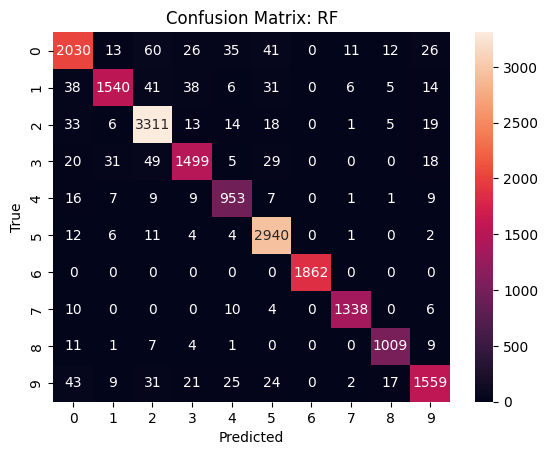

              precision    recall  f1-score   support

           0       0.91      0.88      0.89      2254
           1       0.91      0.89      0.90      1719
           2       0.95      0.96      0.95      3420
           3       0.91      0.88      0.89      1651
           4       0.83      0.92      0.87      1012
           5       0.96      0.98      0.97      2980
           6       1.00      1.00      1.00      1862
           7       0.94      0.98      0.96      1368
           8       0.96      0.96      0.96      1042
           9       0.92      0.89      0.90      1731

    accuracy                           0.94     19039
   macro avg       0.93      0.93      0.93     19039
weighted avg       0.94      0.94      0.94     19039



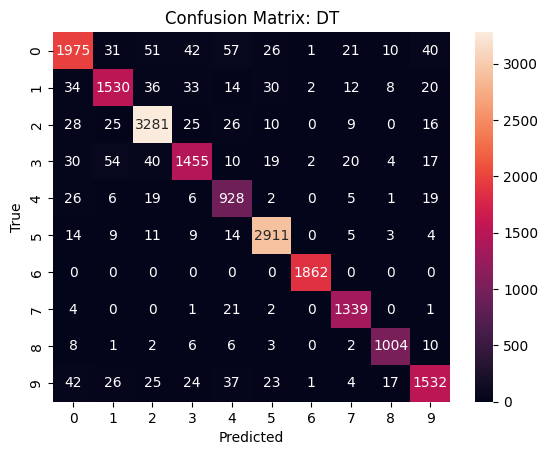

              precision    recall  f1-score   support

           0       0.58      0.55      0.56      2254
           1       0.61      0.46      0.53      1719
           2       0.53      0.67      0.59      3420
           3       0.47      0.41      0.43      1651
           4       0.61      0.65      0.63      1012
           5       0.50      0.67      0.57      2980
           6       0.97      1.00      0.98      1862
           7       0.51      0.16      0.24      1368
           8       0.64      0.64      0.64      1042
           9       0.57      0.46      0.51      1731

    accuracy                           0.59     19039
   macro avg       0.60      0.57      0.57     19039
weighted avg       0.59      0.59      0.57     19039



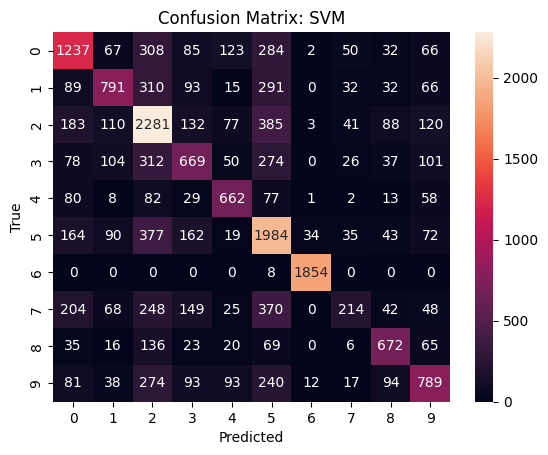

              precision    recall  f1-score   support

           0       0.58      0.52      0.55      2254
           1       0.62      0.46      0.53      1719
           2       0.52      0.65      0.58      3420
           3       0.45      0.46      0.46      1651
           4       0.65      0.61      0.63      1012
           5       0.52      0.66      0.58      2980
           6       1.00      0.99      0.99      1862
           7       0.45      0.25      0.32      1368
           8       0.68      0.63      0.66      1042
           9       0.56      0.47      0.51      1731

    accuracy                           0.59     19039
   macro avg       0.60      0.57      0.58     19039
weighted avg       0.59      0.59      0.58     19039



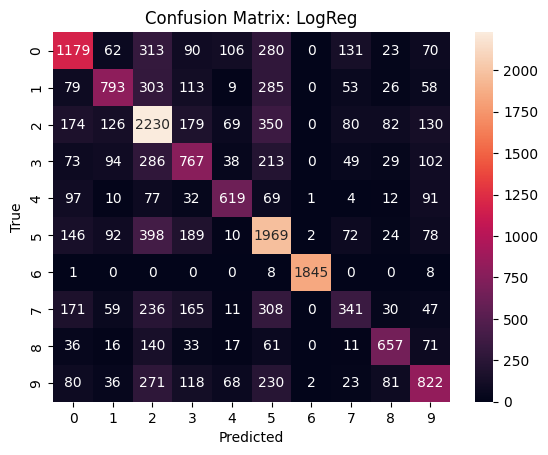

              precision    recall  f1-score   support

           0       0.64      0.66      0.65      2254
           1       0.69      0.61      0.65      1719
           2       0.73      0.78      0.75      3420
           3       0.67      0.51      0.58      1651
           4       0.70      0.69      0.69      1012
           5       0.78      0.82      0.80      2980
           6       1.00      1.00      1.00      1862
           7       0.74      0.87      0.80      1368
           8       0.76      0.84      0.80      1042
           9       0.73      0.64      0.68      1731

    accuracy                           0.75     19039
   macro avg       0.74      0.74      0.74     19039
weighted avg       0.74      0.75      0.74     19039



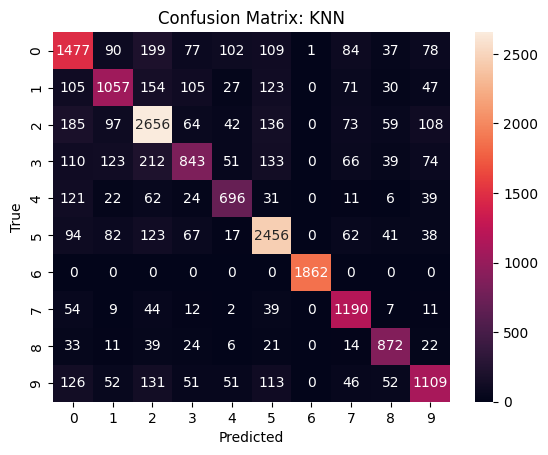

              precision    recall  f1-score   support

           0       0.56      0.57      0.57      2254
           1       0.63      0.50      0.56      1719
           2       0.59      0.62      0.60      3420
           3       0.45      0.43      0.44      1651
           4       0.59      0.67      0.63      1012
           5       0.56      0.74      0.64      2980
           6       1.00      1.00      1.00      1862
           7       0.48      0.34      0.40      1368
           8       0.79      0.65      0.71      1042
           9       0.59      0.49      0.54      1731

    accuracy                           0.62     19039
   macro avg       0.62      0.60      0.61     19039
weighted avg       0.62      0.62      0.61     19039



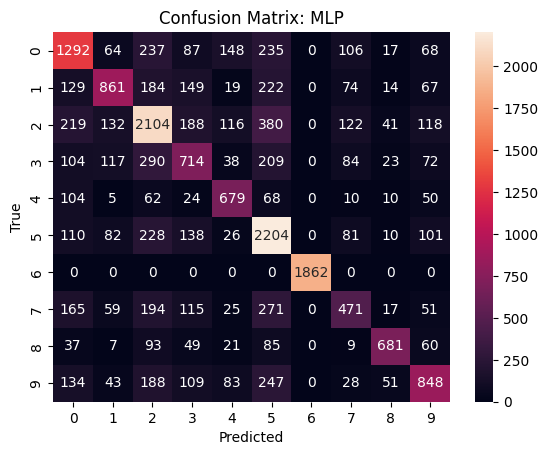

In [6]:
for model_name in models:
    print(classification_report(y_test, all_preds[model_name]))
    cm = confusion_matrix(y_test, all_preds[model_name])
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title(f"Confusion Matrix: {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()